In [1]:
import numpy as np
import psana as ps
import matplotlib.pyplot as plt
import sys
import time
import pickle
import os
from Functions import *
from raw_data_class import RawData as RDC
from processed_data_class import processed_data_class as PDC
%matplotlib notebook

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
save_dir = '/cds/home/b/bpoult/sample_data/'
calib_dir = '/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/'
runs = np.arange(230,239) # goes from first value in range to last - 1
epix_roi = [80,140,170,330]
xrt_roi = [725,1500]
calibration_file = 'calibration_2'

# Processing or Loading
process_raw = False
on_off = False # Do you want to plot the raw data?
plot_one = 238
plot_one_idx = np.searchsorted(runs,plot_one)
x_axis = 'energy' # 'pixels' or 'energy'
to_cal_file = [calib_dir, calibration_file]

In [3]:
# Energy Calibration, plot raw calibration runs with pixel axis and populate these arrays
save_cal = False
if save_cal is True:
    calib_runs = list(range(230,238))
    notch_energies = [6.985,6.990,6.995,7.000,7.005,7.010,7.015,7.020] # keV
    xrt_pixels = [1412,1321,1237,1150,1065,980,896,810] # enter 0 if you can't see the notch
    epix_pixels = [0,243,256,269,282,295,0,0] # enter 0 if you can't see the notch

    labels = ['notch_energies','xrt_pixels','epix_pixels','rois','to_cal_file','calib_runs']
    rois = [xrt_roi,epix_roi]
    calib_in = [labels, notch_energies,xrt_pixels,epix_pixels,rois,to_cal_file,calib_runs]
    calib_out = energy_calib.energy_calib(calib_in,save_cal)
    print('')
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]
if os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl') and save_cal is False:
    with open(to_cal_file[0] + to_cal_file[1] +'.pkl', "rb") as f:
        calib_out = pickle.load(f)
    print('The loaded calibration settings are: ')
    current_cal = [print(calib_out[0][i] +' : '+ str(calib_out[i+1])) for i in list(range(0,5))+list(range(8,10))]   
    
if not os.path.exists(to_cal_file[0]+to_cal_file[1]+'.pkl'):
    print(to_cal_file[1] + ' does not exist.')
    print('No calibration file loaded.')

The loaded calibration settings are: 
notch_energies : [6.985, 6.99, 6.995, 7.0, 7.005, 7.01, 7.015, 7.02]
xrt_pixels : [1412, 1321, 1237, 1150, 1065, 980, 896, 810]
epix_pixels : [0, 243, 256, 269, 282, 295, 0, 0]
rois : [[725, 1500], [80, 140, 170, 330]]
to_cal_file : ['/cds/home/b/bpoult/LCLS_LV_27_Data_Analysis/calibrations/', 'calibration_2']
epix_motor : 32.18824
time_calibrated : 2021-05-26 01:58:52.289137


In [4]:
# Raw Data
raw_datas = []
for run in runs:
    scan_name = 'run_' + f'{run:03}'
    ds_string = 'exp=cxix46119:run='+str(run)+':smd'
    print(ds_string)
    if process_raw:
        raw_data = load_data.load_data(save_dir,scan_name,ds_string,epix_roi,xrt_roi)
    else:
        if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
            with open(save_dir + scan_name + "/" + "rawdata.pkl", "rb") as f:
                raw_data = pickle.load(f)
        else:
            print('You are trying to load a file that does not exist.')
    if os.path.exists(save_dir + scan_name + "/" + "rawdata.pkl"):
        raw_datas = raw_datas + [raw_data]

[load_data.add_cal_info(raw_datas[i],to_cal_file) for i in range(0,len(raw_datas))]
plot_raw.plot_raw(raw_datas, plot_one, x_axis, on_off,to_cal_file)

exp=cxix46119:run=230:smd
exp=cxix46119:run=231:smd
exp=cxix46119:run=232:smd
exp=cxix46119:run=233:smd
exp=cxix46119:run=234:smd
exp=cxix46119:run=235:smd
exp=cxix46119:run=236:smd
exp=cxix46119:run=237:smd
exp=cxix46119:run=238:smd
Raw Data plotting is turned off.


In [5]:
# Applys an energy window to both spectra. Decide on window based on epix spectrum above.
# Also, reduces the resolution of the xrt spectrometer to match that of the epix.
energy_window = [6.986,7.0158]
for i in range(0,len(raw_datas)):
    reduce_xrt_res.apply_window(raw_datas[i],energy_window)
    reduce_xrt_res.reduce_res(raw_datas[i])


# plt.figure()
# plt.plot(raw_data.epix_energy_windowed,np.sum(raw_data.xrt_red_res,0))
# plt.plot(raw_data.xrt_energy_windowed,np.sum(raw_data.xrt_windowed,0),alpha=0.5)
# plt.show()

In [6]:
# Inputs for filters
# filters = [filter0,filter1, ...,filterN]

            # filterX[0] = On/Off # True or False
            # filterX[1] = Type # 'bounds','linearity','rms'
            # filterX[2] = [par0,par1,...,parN]
            
                # If Type = 'bounds'    # par0 = 'key_0' # key_X is string from raw_data.getKeys()
                                        # par1 = lower bound # check raw_data.keyX for starting point 
                                        # par2 = upper bound # 'None' if no upper bound
                                        # par3 = number of stds from median allowed
            
                # If Type = 'linearity' # par0 = 'key_0','key_1' # key_0 and key_1 and x and y values, respectively
                                        # par1 = width of filter
                    
# filterX[3] = [in_1, in_2]
                # in_1 = On/Off # True or false
                # in_2 = plot_one # The run you want to see plots for. Declared above in the 2nd block.

# print(raw_data.getKeys()) 
suspress_output = True
filt0 = [True,'bounds',['low_diode_us',0.285,'None',1.7],[False,plot_one]]
filt1 = [True,'bounds',['high_diode_us',0.26,'None',1.5],[False,plot_one]]
filt2 = [True,'bounds',['photon_energies',0.95,'None',0.75],[False,plot_one]]
filt3 = [True,'bounds',['pulse_energies_fee',0.43,'None',1.5],[False,plot_one]]

# The linearity filters create their fit based on data points that make it through
# the bounds filters.

filt4 = [True,'linearity',['xrt_intensity','epix_intensity',0.08],[False,plot_one]]
filt5 = [True,'linearity',['low_diode_us','epix_intensity',0.1],[False,plot_one]]
filt6 = [True,'linearity',['low_diode_us','xrt_intensity',0.1],[False,plot_one]]

filters = [filt0,filt1,filt2,filt3,filt4,filt5,filt6]
conditions = [Filters.filtering(raw_datas[i],filters,suspress_output) for i in range(0,len(raw_datas))]

Filter info for run_238:
Filter0 removed 2483 unique shots out of 33994 total shots.
Filter1 removed 3372 unique shots out of 33994 total shots.
Filter2 removed 9 unique shots out of 33994 total shots.
Filter3 removed 730 unique shots out of 33994 total shots.
Filter4 removed 2622 unique shots out of 33994 total shots.
Filter5 removed 1735 unique shots out of 33994 total shots.
Filter6 removed 591 unique shots out of 33994 total shots.
The combined filters removed 11542 shots out of 33994 total shots.



New spec scaling made fromrun_238

RMSE filter information for run run_238
The epix rmse condition removed 332 out of 22452 shots.
The xrt rmse condition removed 50 out of 22452 shots.
Both rmse conditions removed 347 out of 22452 shots.



<IPython.core.display.Javascript object>


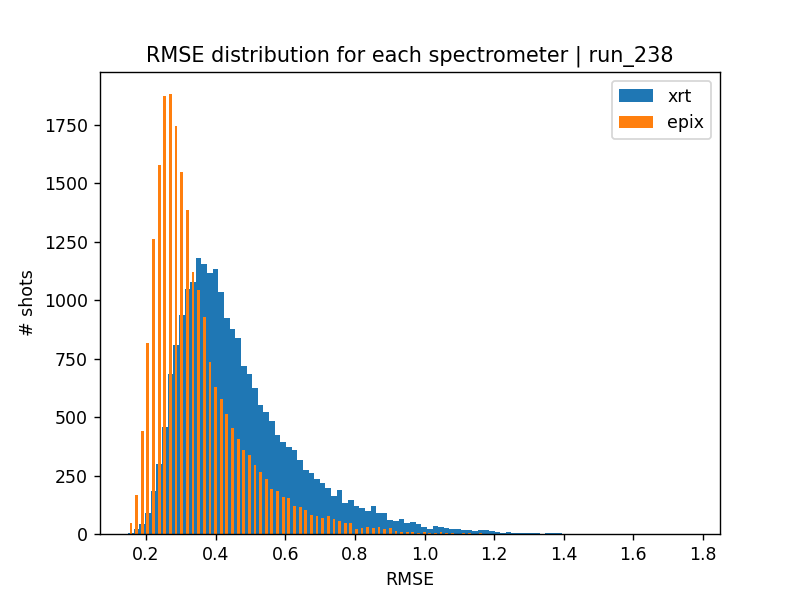

In [7]:
# Make or load processed data
make_pro = True
pro_datas = []
probe_run = [238,make_pro]

for i in range(0,len(raw_datas)):
    if make_pro:
        if i is 0:
            new_scale = raw_datas[np.searchsorted(runs,probe_run[0])].make_pro_data(conditions[np.searchsorted(runs,probe_run[0])],filters)
            probe_run = new_scale.scale_spectrometers(probe_run)
        processed_data = raw_datas[i].make_pro_data(conditions[i],filters)
        pro_datas = pro_datas + [processed_data]
    else:
        if os.path.exists(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl"):
            with open(raw_datas[i].save_dir + raw_datas[i].scan_name + "/" + "pro_data.pkl", "rb") as f:
                processed_data = pickle.load(f)
                pro_datas = pro_datas + [processed_data]
                print('Loaded processed_data for run ' + processed_data.scan_name)
        else:
            print('You are trying to load a file that does not exist.')
        
    pro_datas[i].scale_spectrometers(probe_run)
rms_parameters = [[1,1],plot_one,False] # [[min_rmse_epix, min_rmse_xrt],plot_all,plot_one]
                                        # plot_one: Run # you want to plot, or 'None'
                                        # plot_all: True or False to plot histograms for each run in pro_datas
suspress_output = True
rms_conditions = [Filters.rms_filter(pro_datas[i],rms_parameters,suspress_output) for i in range(0,len(pro_datas))]

<IPython.core.display.Javascript object>


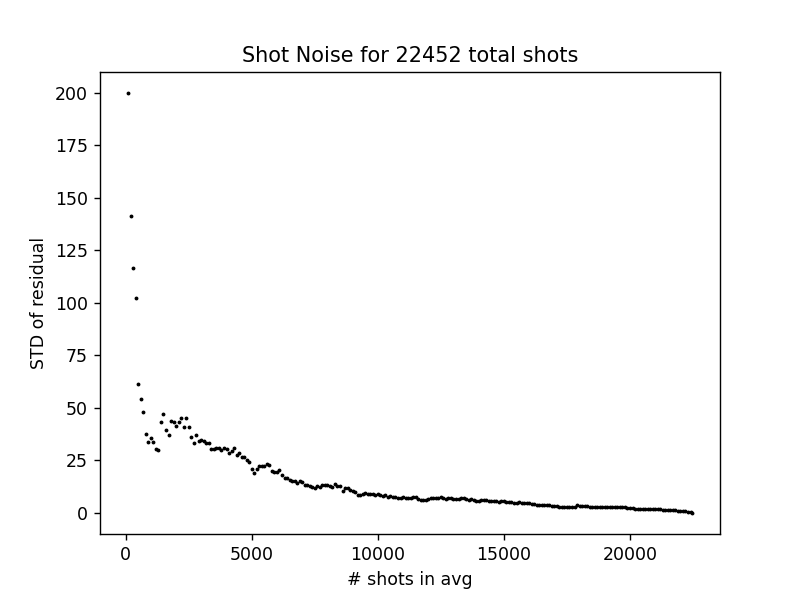

In [8]:
# Plotting the processed data
# plot_pro      .check_SN(processed_data, On/Off): Starts off with randomizing order of shots.
                    # Each data point corresponds to the standard deviation
                    # of the mean of x residuals; epix_spectrum-xrt_spectrum.
                    # Should give us an idea of how signal/noise improves with averaging.
                    # Smoothness of curve could also report on effectiveness of filters.
resid = plot_pro.check_SN(pro_datas[plot_one_idx],True)




In [9]:
total_I_epix = processed_data.epix_intensity
total_I_xrt = processed_data.xrt_intensity
energy = processed_data.epix_energy_windowed
events = processed_data.eventIDs
epix = processed_data.epix_windowed
xrt = processed_data.xrt_based
epix_avg = np.mean(epix,0)
xrt_avg = np.mean(xrt,0)

epix_norm = epix/np.max(epix_avg)
xrt_norm = xrt/np.max(xrt_avg)
epix_avg_norm = epix_avg/np.max(epix_avg)
xrt_avg_norm = xrt_avg/np.max(xrt_avg)


epix_rms = np.sqrt(np.mean(np.subtract(epix_avg_norm,epix_norm)**2,1))
xrt_rms = np.sqrt(np.mean(np.subtract(xrt_avg_norm,xrt_norm)**2,1))
